In [1]:
import spacy
import pickle
from spacy import displacy
nlp = spacy.load('en_core_web_trf')
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import collections
import re
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
parts = ['Beak', 'Head', 'Iris', 'Pupil', 'Mantle',
         'Lesser coverts', 'Scapulars', 'Coverts', 'Tertials',
         'Rump', 'Primaries', 'Vent', 'Thigh',
         'Tibio-tarsal articulation', 'Tarsus', 'Feet',
         'Tibia', 'Belly', 'Flanks', 'Breast', 'Throat',
         'Wattle', 'Eyestripe',]

In [3]:
data = pickle.load(open('../../data/description/04_TRAIN_0-2210_BIRDS.pkl', 'rb'))

In [4]:
sents = [sent for sent in data['Common Tern']]

In [5]:
URL = 'https://en.wikipedia.org/wiki/Glossary_of_bird_terms'

In [6]:
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, "lxml", from_encoding="iso-8859-1")   

In [7]:
glossaries = soup.find_all('dt', {'class': 'glossary'})
parts = [part.text.lower().strip() for part in glossaries]

In [8]:
glossaries_other = soup.find_all('span', {'class': 'anchor'})
parts_other = [part['id'].lower().strip() for part in glossaries_other]

In [9]:
parts = list(set((parts + parts_other)))

In [10]:
len(parts)

1163

In [12]:
sents[0]

'The Common Tern is a medium-sized sea-tern, with total length 32–39 cm, including elongated outer tail feathers forming a 6–9 cm fork, body mass 97–146 g and wingspan 72–83 cm.'

In [13]:
string = sents[0]
doc = nlp(string)

In [263]:
displacy.render(doc)

In [259]:
sents[0:10]

['The Common Tern is a medium-sized sea-tern, with total length 32–39 cm, including elongated outer tail feathers forming a 6–9 cm fork, body mass 97–146 g and wingspan 72–83 cm.',
 'The breeding adult  is characterized by light gray upperparts , pale gray underparts , a black cap, orange-red legs, and an orange-red bill with a black tip.',
 'Extensive black on the outer primaries is conspicuous on the closed wing, although it is covered by white ‘frosting’ when the feathers are freshly molted.',
 'Streamers of forked tail relatively short, not extending beyond wingtips at rest.',
 'In flight, both the leading and trailing edges of the outer primaries are dark.',
 'black inner webs of the primaries show as a dark wedge in the spread wing.',
 'The outer edges of the tail feathers are dark gray.',
 'the rump and uppertail-coverts are white, contrasting with the gray back.',
 'In May–June, the bill is usually orange-red with a black tip, but some birds have extensive black on the culmen.'

In [37]:
species = 'Common Tern'

descriptions = collections.defaultdict(list)

for idx, sentence in enumerate(tqdm(sents)):
    doc = nlp(sentence)
    # Check single
    words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] 
    # Check multiple
    words += [chunk.root.text.lower() for chunk in doc.noun_chunks]
    # Drop duplicate
    words = list(set(words))
    # Exttract root
    root = next(token for token in doc if token.dep_ == 'ROOT')
    #print(words)
    traits =  set(words) & set(parts)
    if traits:
        #print(traits)
        # Yield the traits
        trait_list = list(traits)
        for trait in trait_list:
            #print(trait)
            for token in doc:
                #print(token)
                if token.lemma_.lower() == trait or token.text.lower() == trait:
                    #print(doc[token.i - 2].dep_)
                    # Reconstruct compounds:
                    if doc[token.i - 1].dep_ == 'compound':
                        span = doc[token.i - 1 : token.i + 1]
                    elif doc[token.i - 2].dep_ == 'compound':
                        span = doc[token.i - 2 : token.i + 1]
                    else:
                        span = doc[token.i]
                    
                    # Append to species
                    descriptions[species].append((species, 'has', span.lemma_.lower()))

                    # Check children
                    for child in token.children:
                        # Amods
                        if child.pos_ == 'ADJ' and child.dep_ == 'amod':
                            #print(child.text)
                            descriptions[species].append((span.lemma_.lower(), 'be', child.lemma_.lower()))
                            # Check the children of amods
                            for grandchild in child.children:
                                if grandchild.pos_ == 'ADJ' and grandchild.dep_ == 'amod':
                                    #print(child.text)
                                    descriptions[species].append((child.lemma_.lower(), 'be', grandchild.lemma_.lower()))                                
                        # Appos (length etc.)
                        if child.dep_ == 'appos':
                            appos = ''
                            for subs in token.subtree:
                                if subs.text != token.text:
                                    appos += f'{subs.lemma_ }'
                            descriptions[species].append((span.lemma_.lower(), 'be', appos))
                    
                    try:
                        # Get first ancestor
                        parent = next(parent for parent in token.ancestors)
                        # Or parent of parent
                        if token.dep_ == 'conj' and token.pos_ == 'NOUN': parent = next(grandparent for grandparent in parent.ancestors)
                        if parent.pos_ in ['AUX', 'VERB']:
                            for child in parent.children:
                                if child.dep_ == 'acomp':
                                    descriptions[species].append((span.lemma_.lower(), 'be', child.lemma_.lower()))
                    except:
                        continue
                    
                    #print(parent, token)
                    #for parent in token.ancestors:
                    #    print(parent.dep_, token)
                            
                    
                    
                             
            
                    
                
                        
                    


100%|███████████████████████████████████████████| 164/164 [00:17<00:00,  9.48it/s]


In [28]:
doc

The outer edges of the tail feathers are dark gray.

In [27]:
descriptions[species]

[('Common Tern', 'has', 'tail feather'),
 ('Common Tern', 'has', 'tail feather')]

In [29]:
displacy.render(doc)

In [38]:
source   = []
relation = []
target   = []


for triple in descriptions[species]:
    if not all(triple):
        continue
    source.append(triple[0])
    relation.append(triple[1])
    target.append(triple[2])
    
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

In [39]:
# Drop empty edges
trait_list = list(kg_df[kg_df.source == 'Common Tern']['target'])
df_test = pd.concat([kg_df[kg_df.source == 'Common Tern'], kg_df[kg_df['source'].isin(trait_list)]])
kg_df = df_test

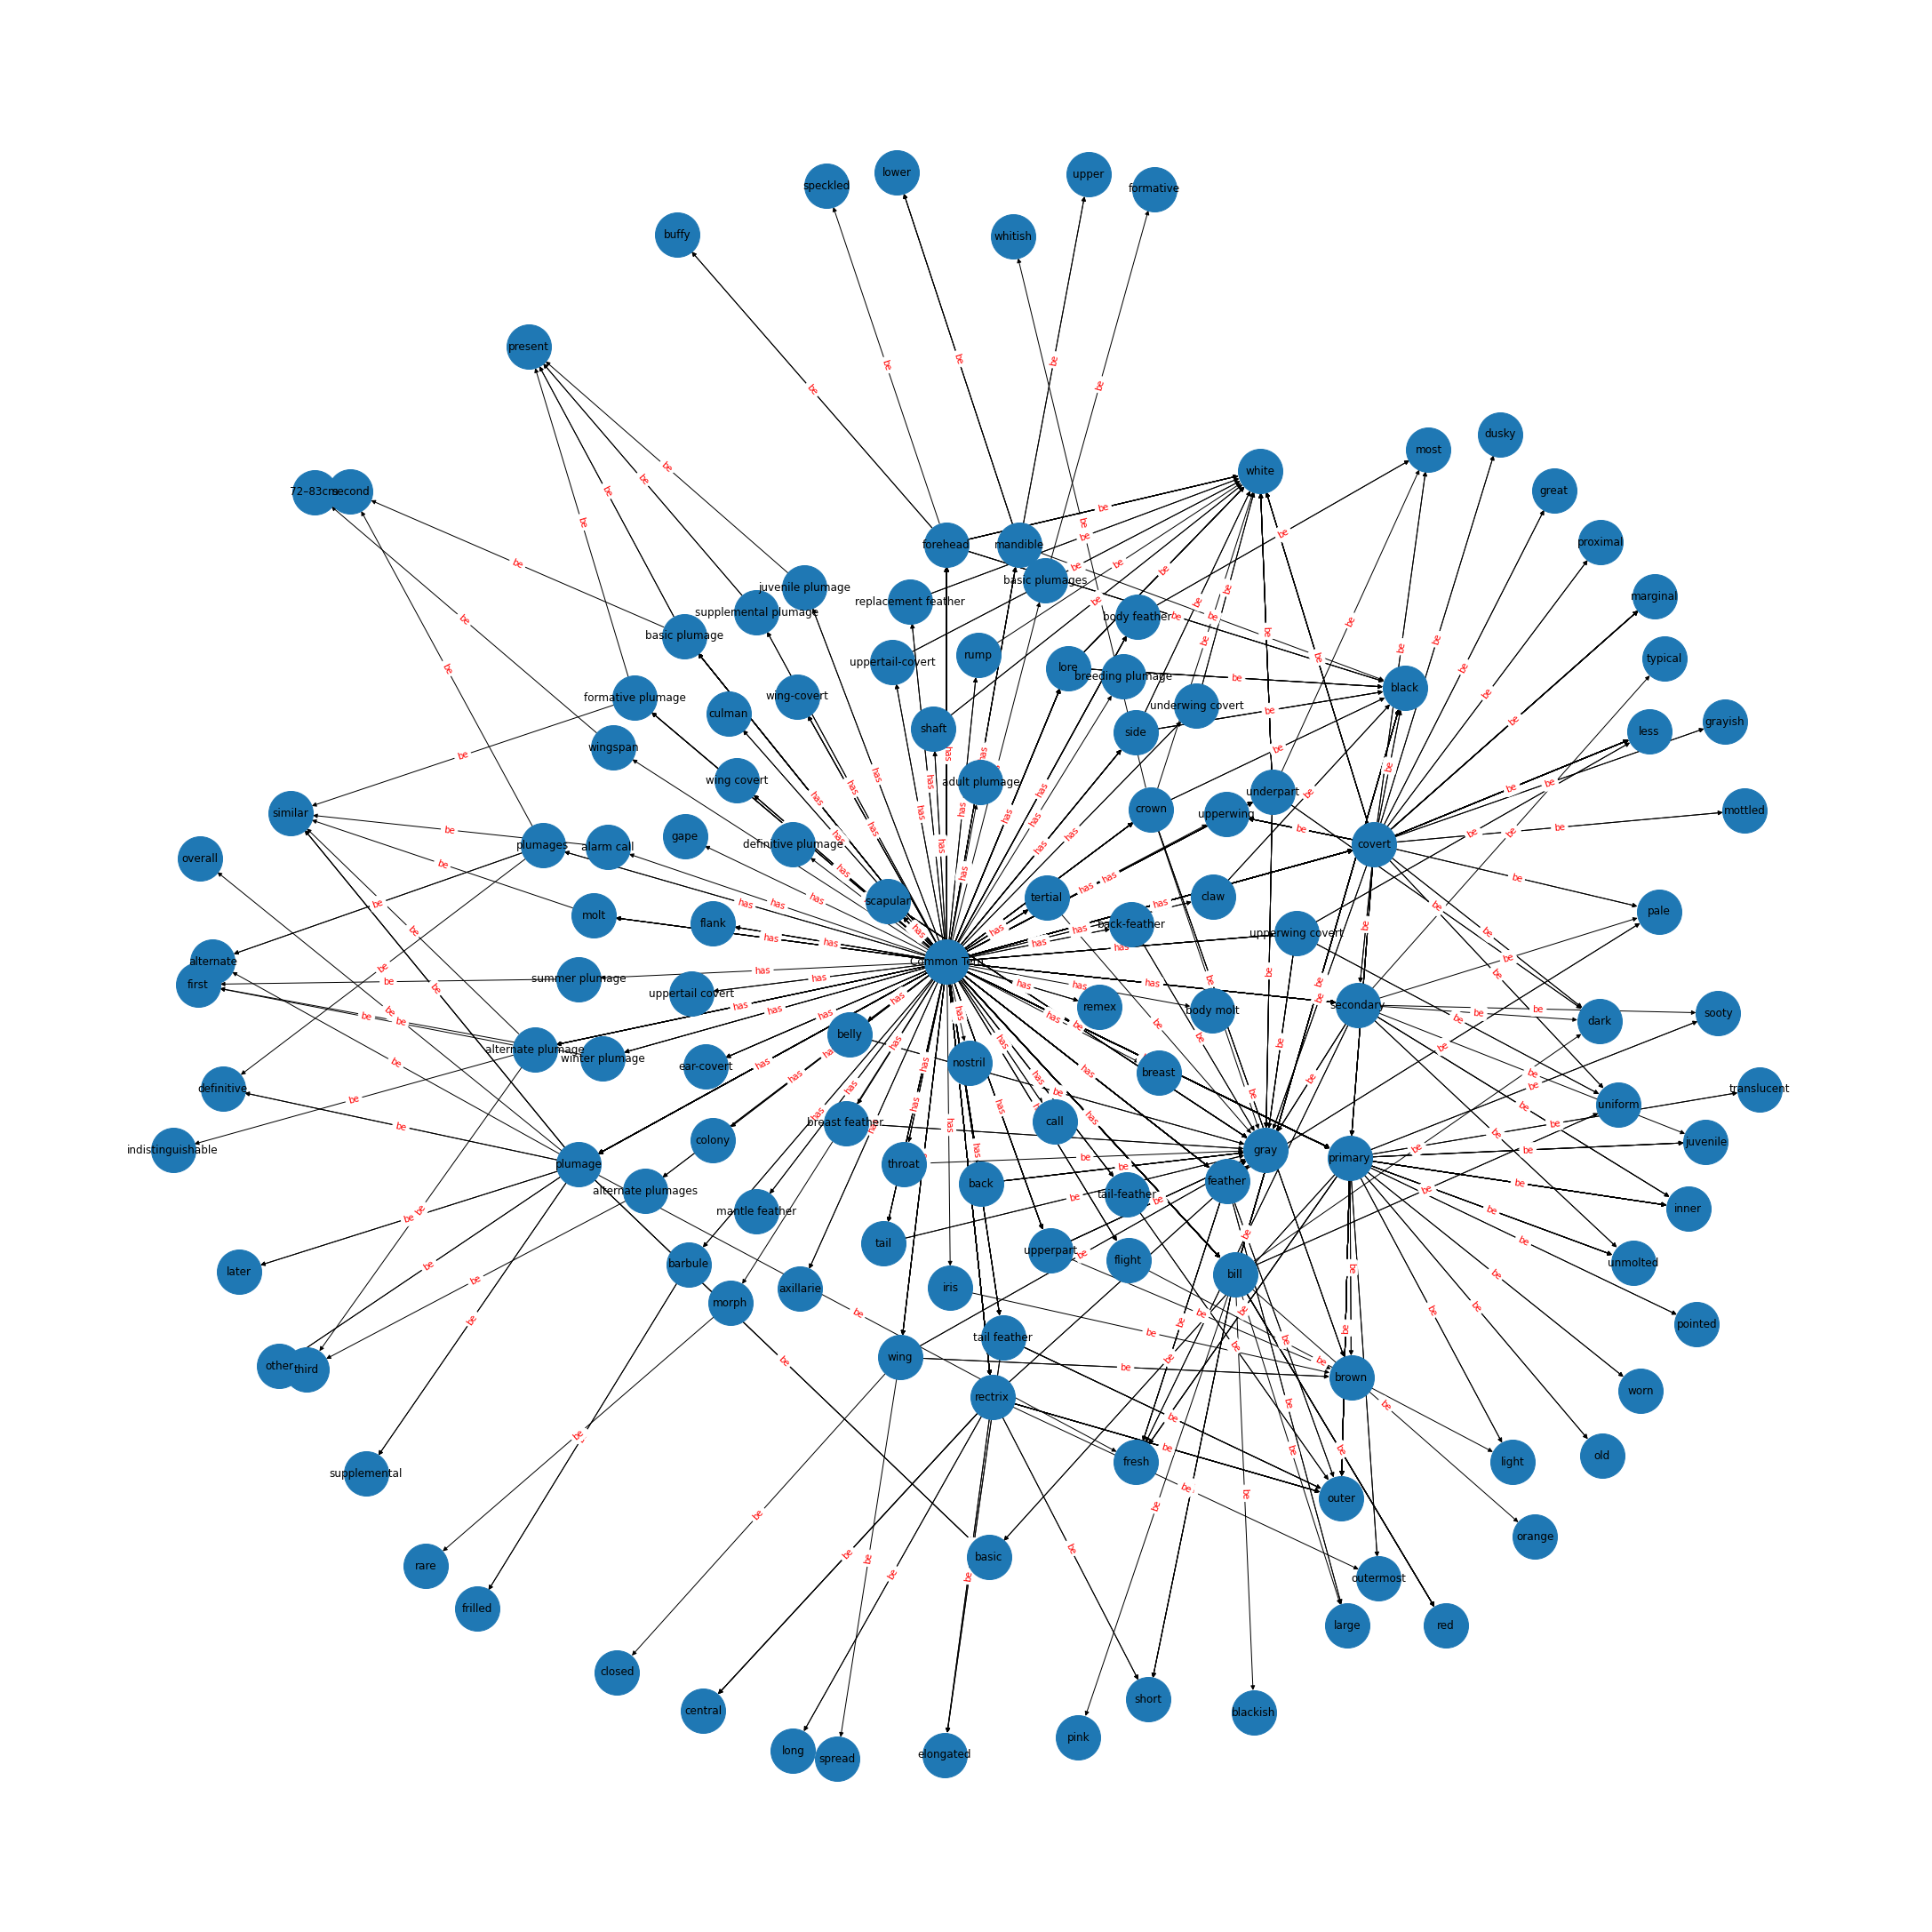

In [40]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(30, 30))
labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))
pos = nx.spring_layout(G, k = 1)
nx.draw(G, with_labels=True, node_size=2500, pos=graphviz_layout(G))
nx.draw_networkx_edge_labels(G, pos=graphviz_layout(G), edge_labels=labels,
                                 font_color='red')
plt.show()
#plt.savefig('plot.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [63]:
strings = ['the Brown bears have 4 long claws and 2 short ears.',
           'The Brown bear has a brown fur.',
            'The Brown bear has a black nose.',
            'The Brown bear has a large nose.',
            'The Brown bear has a bold belly.',
            'Their feet are orange.',
            'The Brown bear has similar feet as the black bear.',
            'The claws have 5 sharp nails and are 8.5 cm long.',
            'The belly is bold and grey',
            'The nose is black and shiny',
            'It has dark ears',
            'legs muscular with curved nails'
          ]


In [64]:
string = strings[0]
doc = nlp(string)

In [65]:
displacy.render(doc)